# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

* Initial State: An empty 6x7 board
* Actions: Placing a disk in a spot on the grid that is empty and is either on the bottom row or has another piece below it
* Transition Model: Action replaces an empty spot on the grid, then the following action would replace another empty spot
* Goal State:
    * Terminal: The terminal state test is when there is either four disks of the same color adjacent to one another either vertically, horizaontally, or diagonally or when there are no more actions that can be taken indicating a draw.
    * Utility: Determine if the player wins the game or loses the game.

How big is the state space? Give an estimate and explain it.

The state space is $42^3$ because there are 3 possible states for each position on the 6 by 7 grid. This is not true because this implies each column ccan have a disk on any row even when there is not a disk located below it. The actual state space is likely much lower than the estimate. When searching for the state space, google gave the answer to be approximately $4.5*1012$.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The game tree search will be approximately 21 on a log base 10 scale. This is the branching factor raised to the number of turns taken.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [2]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

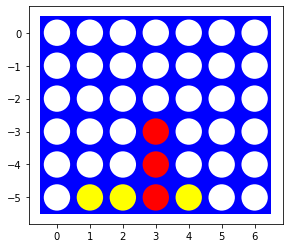

In [3]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [11]:
def actions(board):
    options = []
    for col in range(len(board[0])):
        if board[0][col] == 0:
            options.append(col)
    return options

def result(board, actions, player=1):
    b = board.copy()
    i = actions
    if board[0][i] != 0:
        return False
    
    nextRow = len(board) -1 
    for row in range(len(board)):
        if b[row][i] != 0:
            nextRow = row -1
            break
                
    b[nextRow][i] = player
    
    return b
def get_series(board):
    connects = []
    
    for row in range(len(board)):
        connects.append(board[row])
        
    for col in range(len(board)):
        connects.append(board[:,col])
        
    for offset in range(1-len(board),len(board[0])):
        connects.append(np.diagonal(board, offset=offset))
        connects.append(np.diagonal(np.fliplr(board), offset=offset))
        
    max_rc = max(len(board),len(board[0]))
    return connects

def is_winner(series):
    count = 0
    prev = 0
    for current in series:
        if current != 0 and current == prev:
            count += 1
        elif current != 0 and current != prev:
            count = 1
            prev = current
        elif current == 0:
            prev = 0
            count = 0
            
        if count == 4:
            return prev
    
def terminal(board):
    if len(actions(board)) == 0:
        return "draw"
    
    series = get_series(board)
    for s in series:
        winner = is_winner(s)
        if winner is not None:
            return winner
    
    return "continue"

def switch(player):
    if player == 1:
        return -1
    else:
        return 1
    
def utility(board, player = 1):
    winner = terminal(board)
    if winner == player:
        return +1
    if winner == switch(player):
        return -1
    if winner == "draw":
        return 0
    return None

def connect4(player1, player2, starting = 1,  turns = 30, n = 6, m = 7):
    board = empty_board(shape=(n,m))
    i = 0
    while terminal(board) == "continue" and i < turns:
        i += 1
        ms = actions(board)
        m = player1(board,ms)
        board = result(board=board, actions=m, player=starting)
        
        if terminal(board) != "continue":
            winner = utility(board,starting)
            return board
        
        starting = switch(starting)
        
        ms = actions(board)
        m = player2(board,ms)
        board = result(board=board, actions=m, player=starting)
        
        if terminal(board) != "continue":
            winner = utility(board, starting)
            return board
    return board    

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [12]:
import random
def random_player(board, player = None):
    options = actions(board)
    
    if len(options) == 0:
        return None
    return random.choice(options)

In [13]:
board = empty_board(shape=(6,7))
len(board[0])

7

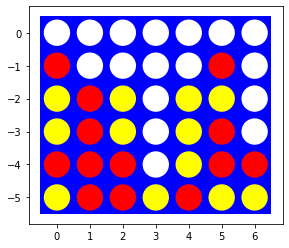

In [14]:
board=connect4(random_player,random_player, starting =1)
visualize(board)

In [9]:
print(" Red Utility: ", utility(board, player=1))
print("Yellow Utility: ", utility(board, player=-1))

 Red Utility:  -1
Yellow Utility:  1


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [8]:
p1Wins = 0
p2Wins = 0
draws = 0
games = []

for i in range (1000):
    board = connect4(random_player,random_player,starting=1)
    winner = terminal(board)
    if winner == 1:
        p1Wins = p1Wins+1
    elif winner == -1:
        p2Wins = p2Wins+1
    else:
        draws = draws+1
    games.append(board)
print('Player 1: ', p1Wins)
print('Player 2: ', p2Wins)
print('Draw: ', draws)

Player 1:  492
Player 2:  480
Draw:  28


The result of the tests was expected as the number of wins for each player is relatively the same with draws being a rarity. With random agents, the odds being similar to a coin-flip are expected.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [15]:
import math
DEBUG = 0 #set to have debug messages
COUNT = 0


def randomize(board):
    options = actions(board)
    random.shuffle(options)
    return options

def alpha_beta_search(board, player=1, actions = randomize):
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab(board, player, -math.inf, +math.inf, actions=actions)
    
    if DEBUG >= 0: 
        print("Number of nodes searched: ", COUNT)
    return value, move

def max_value_ab(board, player, alpha, beta, actions=actions):
    #Best players move
    v = utility(board,player)
    global DEBUG, COUNT
    COUNT += 1
    if DEBUG == 1: 
        print("max: \n" + str(board) + str([alpha, beta, v]))
        
    if v is not None: 
        return v, None
    
    v, move = -math.inf, None
    
    moves = actions(board)
    for a in moves:
        v2, a2 = min_value_ab(result(board, a, player), player, alpha, beta, actions=actions)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    return v, move

def min_value_ab(board, player, alpha, beta, actions = actions):
    #Opponent best move
    global DEBUG, COUNT
    COUNT += 1
    
    v = utility(board, player)
    if DEBUG == 1: print("min: \n" + str(board) + str([alpha, beta, v]))
    if v is not None: 
        return v, None
    
    v, move = +math.inf, None
    
    moves = actions(board)
    for a in moves:
        v2, a2 = max_value_ab(result(board, a, switch(player)), player, alpha, beta, actions = actions)
        if v2 < v: 
            v, move = v2, a
            beta = min(beta,v)
        if v <= alpha:
            return v, move
        
    return v, move



Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

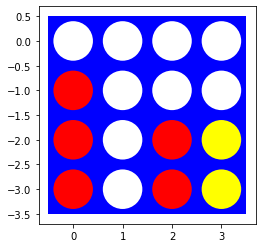

Number of nodes searched:  155
Wall time: 41.7 ms


(1, 0)

In [16]:
board = connect4(random_player, random_player, turns = 2, n=4, m=4)
board[2][0] = 1
board[1][0] = 1
board[3][0] = 1
board[0][0] = 0
visualize(board)
%time alpha_beta_search(board, actions = actions, player = 1)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

The simplest strategy in connect4 is to start by placing pieces toward the center of the board first instead of the outer sides of the board.

In [ ]:
def center_first(board):
    moves = actions(board)
    cols = board.shape[1]
    new_order = []
    if board[0][cols//2] == 0:
        new_order.append(cols)
    for i in range(1, cols//2+1):
        idx = (cols//2) + i
        if idx < cols and board[0][idx] == 0:
            new_order.append(idx)
        idx = (num_cols//2) - i
        if idx >= 0 and board[0][idx] == 0:
            new_order.append(idx)
    
    new_moves = []
    for x in new_order:
        for v in moves:
            if v == x:
                new_moves.append(v)

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In order to reduce the runtime, we can limit the number of columns available for the search by only assesing the center 4 columns of the board since large boards increase the number of possible combinations of boards.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
def minimax_agent(board, player = 1):
    v,m = alpha_beta_search(board, player)
    return m

In [ ]:
def agent_center(board, player ='1') :
    v, m = alpha_beta_search(board, player, actions = center_first)
return m

In [ ]:
def play(p1, p2, N = 100):

    winning = {1: 0, -1: 0, 0: 0}
    for i in range(N):
        board = empty_board(shape=(4,4))
        player, agent = 1, p1
        while True:
            a = agent(board, player)
            board = results(board, a, player)
            win = terminal(board)
            if win != ' ':
                winning[win] += 1
                break
            player, agent = switch_player(player), p2
    return winning

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [ ]:
# Your code/ answer goes here.

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [ ]:
# Your code/ answer goes here.